In [1]:
import pandas as pd
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster

In [2]:
PREFIX_DATA_PATH = "data"

In [ ]:
# cassandra_db_host="35.187.249.32"
cassandra_db_host="localhost"
cassandra_db_port="9042"

cluster = Cluster([cassandra_db_host], port=cassandra_db_port)
cluster

session = cluster.connect()
session

In [ ]:
system_query = "SELECT keyspace_name FROM system_schema.keyspaces;"
keyspaces = session.execute(system_query)
list(keyspaces)

In [ ]:
keyspace = "scopus_data"
# SCOPUS_DATA_PATH="/Users/punpun/Documents/Personal/cedt/dsde-project/octopus-analysis/data/scopus"

session.set_keyspace(keyspace)

In [ ]:
page_size = 1000
table = "scopus_data.records"
session.default_fetch_size = page_size

rows = session.execute(f"SELECT * FROM {table}")

In [ ]:
df = pd.DataFrame(list(rows))
df

In [ ]:
df.to_csv(f'{PREFIX_DATA_PATH}/12_04_24.csv', index=False)
df.to_parquet(f'{PREFIX_DATA_PATH}/12_04_24.parquet', index=False)

In [ ]:
df.columns

In [ ]:
conference_papers = df[df['document_type'] == 'Conference Paper']
conference_sources = conference_papers['source_title'].value_counts()

# To see what conferences these papers are from
print(conference_sources.head(10))

In [ ]:
df[['source_type', 'document_type']].value_counts()

In [ ]:
df[(df['document_type'] == 'Conference Paper') & (df['source_type'] == 'Conference Proceeding')]

In [11]:
def classify_full_conference_papers(df):
    """
    Classifies only full conference papers, excluding workshops, symposiums, and other
    similar events. This classifier aims to identify papers from established conference
    proceedings with formal peer review processes.

    Parameters:
    df (pandas.DataFrame): DataFrame containing Scopus publication data

    Returns:
    tuple: (DataFrame with classification, statistics dictionary)
    """
    analysis_df = df.copy()

    # Terms that indicate full conference papers
    conference_indicators = [
        "international conference on",
        "proceedings of the",
        "annual conference",
        "international conference in",
        "international conference of",
    ]

    # Terms that should exclude a paper
    exclusion_terms = [
        "workshop",
        "symposium",
        "seminar",
        "colloquium",
        "tutorial",
        "short paper",
        "poster",
        "abstract only",
        "extended abstract",
        "work in progress",
    ]

    def is_full_conference_paper(row):
        """
        Determines if a publication is a full conference paper based on multiple criteria.
        """
        source_title = str(row.get("source_title", "")).lower()
        # publisher = str(row.get("publisher", "")).lower()
        source_type = str(row.get("source_type", "")).lower()

        # Check for exclusion terms first
        if any(term in source_title.lower() for term in exclusion_terms):
            return False

        # Verify it's marked as a conference publication
        if "conference proceeding" not in source_type:
            return False

        # Check for conference indicators
        has_conference_indicator = any(
            indicator in source_title.lower()
            for indicator in conference_indicators
        )

        # Additional quality checks
        ref_count = float(row.get("ref_count", 0))
        has_minimum_references = (
            ref_count >= 5
        )  # Most full papers have substantial references

        # Final classification
        is_conference = (
            has_conference_indicator
            and has_minimum_references
            and not any(
                term in source_title.lower() for term in exclusion_terms
            )
        )

        return is_conference

    # Apply classification
    analysis_df["is_full_conference"] = analysis_df.apply(
        is_full_conference_paper, axis=1
    )

    # Generate detailed statistics
    stats = {
        "total_papers": len(analysis_df),
        "full_conference_papers": analysis_df["is_full_conference"].sum(),
        "percentage_full_conference": (
            analysis_df["is_full_conference"].sum() / len(analysis_df) * 100
        ),
        "total_has_conference_proceeding": len(
            analysis_df[
                analysis_df["source_type"].str.lower().str.contains("conference proceeding")
            ]
        ),
        "total_has_conference_indicator": len(
            analysis_df[
                analysis_df["source_title"].str.lower().str.contains(
                    "|".join(conference_indicators)
                )
            ]
        ),
        "total_has_exclusion_terms": len(
            analysis_df[
                analysis_df["source_title"].str.lower().str.contains(
                    "|".join(exclusion_terms)
                )
            ]
        ),
    }

    return analysis_df, stats


analysis_df, stats = classify_full_conference_papers(df)
stats

{'total_papers': 19007,
 'full_conference_papers': 395,
 'percentage_full_conference': 2.078181722523281,
 'total_has_conference_proceeding': 1249,
 'total_has_conference_indicator': 436,
 'total_has_exclusion_terms': 60}

In [12]:
# visaul ref count
analysis_df[analysis_df["is_full_conference"]]['document_type'].value_counts()

document_type
Conference Paper    395
Name: count, dtype: int64

In [13]:
analysis_df[(analysis_df["is_full_conference"])]

,doi,abstract,affiliation,author_affiliation,author_details,author_given_name,author_keywords,author_surname,author_url,cited_by,...,ref_count,source_title,source_type,status_state,subject_abbrev,subject_area,subject_code,subject_name,title,is_full_conference
114,10.1109/SNPD.2019.8935680,A timed Petri nets would practically represent...,"{""affiliation-city"":""Bangkok"",""@id"":""60028190""...","{""@id"":""60028190"",""@href"":""https://api.elsevie...","[true,6507688023,2,{""@id"":""60028190"",""@href"":""...",Wiwat,"[{""@_fa"":""true"",""$"":""Event-B""},{""@_fa"":""true"",...",Vatanawood,https://api.elsevier.com/content/author/author...,0.0,...,10.0,Proceedings - 20th IEEE/ACIS International Con...,Conference Proceeding,update,DECI,"[Information Systems and Management,true,DECI,...",1802,Information Systems and Management,Transformation of Bounded Timed Petri Nets int...,True
116,10.1109/AIM43001.2020.9158998,Parallel elastic actuation utilizing an elasti...,"[{""affiliation-city"":""Bangkok"",""@id"":""60028190...","{""@id"":""60008435"",""@href"":""https://api.elsevie...","[true,55821756500,4,{""@id"":""60008435"",""@href"":...",Kazuhiro,None,Kosuge,https://api.elsevier.com/content/author/author...,16.0,...,57.0,IEEE/ASME International Conference on Advanced...,Conference Proceeding,new,COMP,"[Software,true,COMP,1712]",1712,Software,A spring-embedded planetary-geared parallel el...,True
135,10.1109/ICME52920.2022.9859613,Estimating 6D pose of the object from a single...,"[{""affiliation-city"":""Bangkok"",""@id"":""60028190...","{""@id"":""60025084"",""@href"":""https://api.elsevie...","[true,24741037600,10,{""@id"":""60025084"",""@href""...",Weiyao,None,Lin,https://api.elsevier.com/content/author/author...,0.0,...,27.0,Proceedings - IEEE International Conference on...,Conference Proceeding,update,COMP,"[Computer Science Applications,true,COMP,1706]",1706,Computer Science Applications,Trace-Level Invisible Enhanced Network for 6D ...,True
182,10.1109/ICSTCC.2019.8885484,It is notable that zinc-ion batteries (ZIBs) s...,"[{""affiliation-city"":""Gif-sur-Yvette"",""@id"":""6...","{""@id"":""60106017"",""@href"":""https://api.elsevie...","[true,9279624600,3,{""@id"":""60106017"",""@href"":""...",Sorin,"[{""@_fa"":""true"",""$"":""Battery management system...",Olaru,https://api.elsevier.com/content/author/author...,3.0,...,16.0,2019 23rd International Conference on System T...,Conference Proceeding,update,ENGI,"[Industrial and Manufacturing Engineering,true...",2209,Industrial and Manufacturing Engineering,Identification of zinc-ion battery via equival...,True
204,10.1109/AIM52237.2022.9863351,Laboratory automation provides a more reliable...,"{""affiliation-city"":""Bangkok"",""@id"":""60028190""...","{""@id"":""60028190"",""@href"":""https://api.elsevie...","[true,57885094600,4,{""@id"":""60028190"",""@href"":...",Nichapat,None,Phondee,https://api.elsevier.com/content/author/author...,0.0,...,13.0,IEEE/ASME International Conference on Advanced...,Conference Proceeding,update,COMP,"[Software,true,COMP,1712]",1712,Software,Affordable Pipetting Robot: Gripper Design for...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18872,10.1109/TSSA.2017.8272932,The behavior of asynchronous hardware system i...,"{""affiliation-city"":""Bangkok"",""@id"":""60028190""...","{""@id"":""60028190"",""@href"":""https://api.elsevie...","[true,6507688023,3,{""@id"":""60028190"",""@href"":""...",Wiwat,"[{""@_fa"":""true"",""$"":""Asynchronous circuit""},{""...",Vatanawood,https://api.elsevier.com/content/author/author...,0.0,...,13.0,Proceeding of 2017 11th International Conferen...,Conference Proceeding,update,MATH,"[Modeling and Simulation,true,MATH,2611]",2611,Modeling and Simulation,Formal modeling for consistency checking of si...,True
18919,10.1109/EMBC46164.2021.9629861,Alzheimer's Disease (AD) and Mild Cognitive Im...,"[{""affiliation-city"":""Pathum Thani"",""@id"":""600...","{""@id"":""127717

<Axes: >

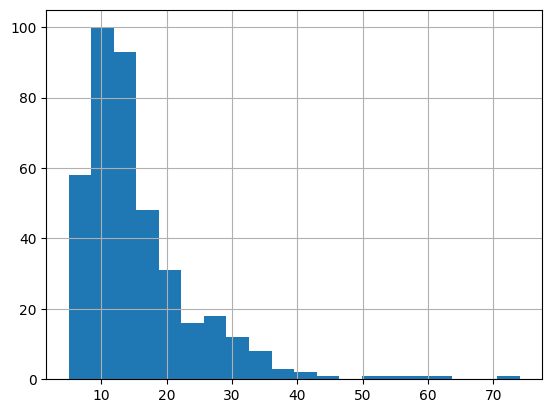

In [14]:
# visaul ref count
analysis_df[analysis_df["is_full_conference"]]['ref_count'].hist(bins=20)

<Axes: >

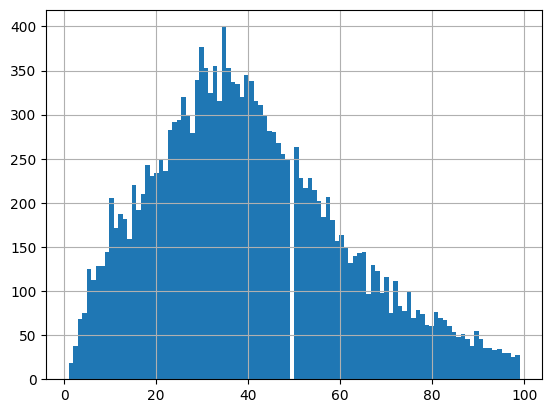

In [15]:
analysis_df[(~analysis_df["is_full_conference"]) & (analysis_df['ref_count'] < 100)]['ref_count'].hist(bins=100)

In [ ]:
analysis_df.columns

In [ ]:
import json
import ast
import re

In [ ]:
# # parse all array and dict if possible
# def parse_complex_columns(df):
#     for column in df.columns:
#         try:
#             # Try parsing as JSON
#             if df[column].dtype == 'object':
#                 try:
#                     df[column] = df[column].apply(lambda x: json.loads(x) if isinstance(x, str) and x.startswith('{') else x)
#                 except:
#                     pass
                
#                 # Try parsing as Array/List
#                 try:
#                     df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
#                 except:
#                     pass
#         except:
#             continue
#     return df

# df = parse_complex_columns(df)
# df

In [ ]:
df.iloc[0].to_dict()

In [16]:
selected_columns = [
    "title",
    "abstract",
    "is_full_conference",
    "subject_name",
    "subject_area",
    "ref_count",
    # "author_details",
    # "author_affiliation",
]
selected_df = analysis_df[selected_columns]
    
# parse first from str to array in subject area [Organic Chemistry,true,CHEM,1605]
selected_df["subject_area"] = selected_df["subject_area"].apply(
    lambda x: x.split(",")[0][1:] if x else None
)


def author_detail_extractor(df):
    num_authors = []
    
    for i, row in df.iterrows():
        # parse to array
        authors = row['author_details']
        if authors:
            try:
                authors = ast.literal_eval(authors)
            except:
                authors = []
        num_authors.append(len(authors))
    
    return num_authors


# author_df = pd.DataFrame(author_detail_extractor(selected_df), columns=['num_authors'])
# selected_df = pd.concat([selected_df, author_df], axis=1)

selected_df

/tmp/ipykernel_12567/2418879158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["subject_area"] = selected_df["subject_area"].apply(


,title,abstract,is_full_conference,subject_name,subject_area,ref_count
0,Lactide Lactone Chain Shuttling Copolymerizati...,The chain shuttling ring-opening copolymerizat...,False,Colloid and Surface Chemistry,Colloid and Surface Chemistry,26.0
1,Developing guidelines for thermal comfort and ...,"In Thailand, many government buildings and fac...",False,"Management, Monitoring, Policy and Law",Management,54.0
2,Characteristics and outcomes of lung cancers d...,Background: Lung cancer screening (LCS) with l...,False,Medicine (all),Medicine (all),48.0
3,Search for light pseudoscalar boson pairs prod...,A search is presented for pairs of light pseud...,False,Nuclear and High Energy Physics,Nuclear and High Energy Physics,68.0
4,Thermosetting Shape Memory Polymers and Compos...,"When dealing with smart polymers, in particula...",False,Organic Chemistry,Organic Chemistry,53.0
...,...,...,...,...,...,...
19002,Electrochemical detection of c-reactive protei...,"In this present work, a novel electrochemical ...",False,Analytical Chemistry,Analytical Chemistry,27.0
19003,Molecular dynamics provides insight into how N...,"Produced by levansucrase, levan and levan olig...",False,Multidisciplinary,Multidisciplinary,65.0
19004,Rhinacanthin-C enhances chemosensitivity of br...,Introduction: High expression of P-glycoprotei...,False,Drug Discovery,Drug Discovery,30.0
19005,"Hydrogen adsorption on zigzag (4,0), (5,0) and...",The adsorption of selected elements from perio...,False,Electrical and Electronic Engineering,Electrical and Electronic Engineering,68.0


In [17]:
selected_df.to_parquet(f'{PREFIX_DATA_PATH}/12_04_24_selected_all.parquet', index=False)